# Customer satisfaction 

#### Converting what people say into a 1 or 5 star rating.

Here I analyse the dataset containing reviews and ratings for different cell phones and accessories products sold through Amazon. Then I use a simple feedforward densely connected deep learning model to develop a classifier that predicts the rating (1 or 5) of a given text review. As such, this is a basic level Natural Language Processing (NLP) project through the use of simple neural networks.

### Source of Data:

https://nijianmo.github.io/amazon/index.html

[1] "Justifying recommendations using distantly-labeled reviews and fined-grained aspects",
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019.

In [1]:
# Data analysis libraries
import numpy as np
import pandas as pd

# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful libraries for NLP
import string
import nltk

In [2]:
# Magic function to display plots in notebook
%matplotlib inline

# Plot style
plt.style.use('ggplot')

In [3]:
# Entire review dataset 
data = pd.read_json("Cell_Phones_and_Accessories_5.json", lines=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   overall         1128437 non-null  int64 
 1   verified        1128437 non-null  bool  
 2   reviewTime      1128437 non-null  object
 3   reviewerID      1128437 non-null  object
 4   asin            1128437 non-null  object
 5   style           605241 non-null   object
 6   reviewerName    1128302 non-null  object
 7   reviewText      1127672 non-null  object
 8   summary         1127920 non-null  object
 9   unixReviewTime  1128437 non-null  int64 
 10  vote            92034 non-null    object
 11  image           27107 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 95.8+ MB


For simplicity, we shall drop all the columns except for overall, summary and reviewText. So, we start with some format changes.

## 1) Data preparation

##### In this section we change the format of the data to suit our needs, clean the data and make it ready for tokenization.

In [5]:
# Creating a new DataFrame containing just the review text, summary and its rating
amazon = data[["reviewText", "overall", "summary"]].copy(deep = True)

In [6]:
# Removing empty review texts
amazon.dropna(subset = ["reviewText"], axis = 0, inplace = True)
amazon.reset_index(inplace = True, drop = True)

In [7]:
# Renaming the columns
amazon.rename(columns = {"reviewText": "Review", "overall": "Rating", "summary": "Summary"}, inplace = True)

In [8]:
# Adding length of the review text into DataFrame
amazon["Review_Length"] = amazon.Review.apply(len)

# Changing the review text to lowercase
amazon.Review = amazon.Review.apply(lambda x: x.lower())

In [9]:
amazon.head(10)

,Review,Rating,Summary,Review_Length
0,looks even better in person. be careful to not...,5,Can't stop won't stop looking at it,271
1,when you don't want to spend a whole lot of ca...,5,1,102
2,"so the case came on time, i love the design. i...",3,Its okay,257
3,don't care for it. gave it as a gift and they...,2,CASE,92
4,"i liked it because it was cute, but the studs ...",4,Cute!,150
5,the product looked exactly like the picture an...,2,Not so happy,159
6,i finally got my case today. it took forever t...,3,It's cute!,344
7,it is a very cute case. none of the jewels hav...,5,Cute case,327
8,do not buy! this item is seriously cheap as he...,1,WORST ITEM!,190
9,i really love this case... you have to keep yo...,4,Pretty Cute!,188


Text(0.5, 1.0, 'Total reviews for entire data')

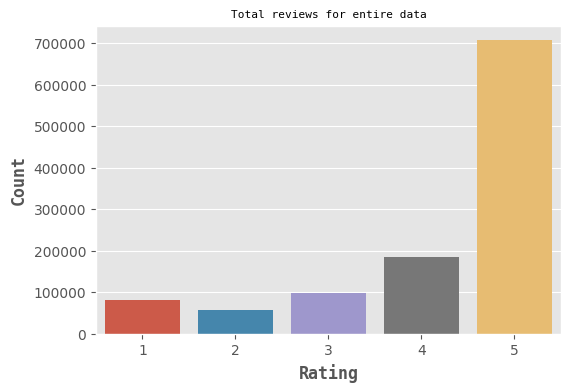

In [10]:
# Plotting the total number of reviews for each rating
fig, ax = plt.subplots(figsize = (6,4), nrows = 1, ncols = 1)
sns.barplot(data = amazon.Rating.value_counts().sort_index().to_frame().reset_index(), y = "Rating", x = "index", ax = ax)
ax.set_xlabel("Rating", family = "monospace", size = 12, fontweight = "bold")
ax.set_ylabel("Count", family = "monospace", size = 12, fontweight = "bold")
ax.set_title("Total reviews for entire data", size = 8, family = "monospace")

We see that the majority of the rating is 5 star. Although good for Amazon, for our classification model this imbalanced dataset poses an issue. The classifier will be biased towards the 5 star rating. To avoid this issue, we will split the data into training, validation and test sets such that each set contains roughly equal number of data points for all the ratings.

To further simplify the task, we will work with binary classfication by removing the 2-4 star ratings.

In [13]:
# DataFrame for each rating: index = 0, rating = 1 while index = 1, rating = 5
amazon_split = []
for i in [1,5]:
    amazon_split.append( amazon[ amazon.Rating == i ].copy(deep = True) )
    
amazon_split[1].Rating.value_counts()

5    706435
Name: Rating, dtype: int64

Let's split the data into smaller chunks of around 5000 points.

In [14]:
# Number of chunks required to obtain around 5000 data points
num = []
for df in amazon_split:
    num.append( df.shape[0]//5000 )
num

[16, 141]

Randomise the datapoints before splitting to obtain a random split.

In [15]:
# Shuffle the rows of the data frame before split
amazon_split_shuffled = []
for df in amazon_split:
    amazon_split_shuffled.append( df.sample(frac = 1, random_state = 123) )

# The rows have been randomised
amazon_split_shuffled[0].head()

,Review,Rating,Summary,Review_Length
1081840,the oneplus 1 and the other one plus phone are...,1,Nothing can help oneplus delicate phones nor t...,700
953928,"screen cracked by it self, 3 days of use, crac...",1,Screen cracked by it self!,147
878071,"very thin plastic, chips easily and broke on m...",1,Avoid this one.,139
697177,very flimsy case; not good quality plastic and...,1,not good quality plastic and image seems like ...,197
44635,bad,1,One Star,3


Splitting the dataset into chunks containing around 5000 rows.

In [16]:
# Split the dataframe into chunks where each chunk contains around 5000 data points
amazon_one_chunks = np.array_split(amazon_split_shuffled[0], num[0])
amazon_five_chunks = np.array_split(amazon_split_shuffled[1], num[1])

print(amazon_five_chunks[0].shape[0], amazon_five_chunks[3].shape[0])

5011 5011


Let's define the train, validate, test data. (The remaining data will be used once I learn to handle larger datasets better.)

In [17]:
# List of dataframes to merge
train = [amazon_one_chunks[0], amazon_five_chunks[0]]
validate = [amazon_one_chunks[1], amazon_five_chunks[1]]
test = [amazon_one_chunks[2], amazon_five_chunks[2]]

# Training chunk
amazon_train = pd.concat( train )
amazon_train.reset_index(inplace = True, drop = True)

# Validating chunk
amazon_validate = pd.concat( validate )
amazon_validate.reset_index(inplace = True, drop = True)

# Testing chunk
amazon_test = pd.concat( test )
amazon_test.reset_index(inplace = True, drop = True)

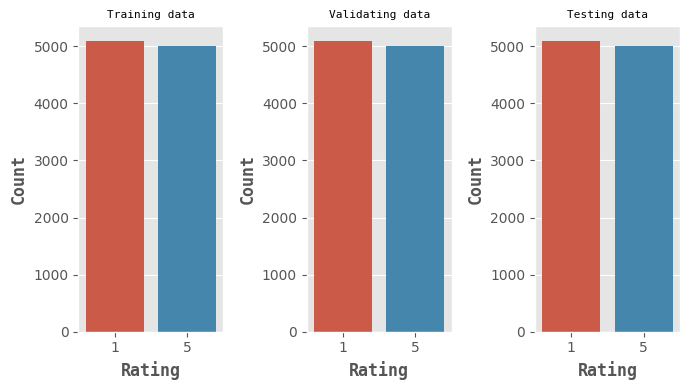

In [18]:
# Replotting the counts for each rating in the train, validate, test datasets
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (7,4))

sns.barplot(data = amazon_train.Rating.value_counts().sort_index().to_frame().reset_index(), y = "Rating", x = "index", ax = ax[0])
ax[0].set_xlabel("Rating", family = "monospace", size = 12, fontweight = "bold")
ax[0].set_ylabel("Count", family = "monospace", size = 12, fontweight = "bold")
ax[0].set_title("Training data", size = 8, family = "monospace")

sns.barplot(data = amazon_validate.Rating.value_counts().sort_index().to_frame().reset_index(), y = "Rating", x = "index", ax = ax[1])
ax[1].set_xlabel("Rating", family = "monospace", size = 12, fontweight = "bold")
ax[1].set_ylabel("Count", family = "monospace", size = 12, fontweight = "bold")
ax[1].set_title("Validating data", size = 8, family = "monospace")

sns.barplot(data = amazon_test.Rating.value_counts().sort_index().to_frame().reset_index(), y = "Rating", x = "index", ax = ax[2])
ax[2].set_xlabel("Rating", family = "monospace", size = 12, fontweight = "bold")
ax[2].set_ylabel("Count", family = "monospace", size = 12, fontweight = "bold")
ax[2].set_title("Testing data", size = 8, family = "monospace")

plt.tight_layout()

Finally, we have arrived at a balanced dataset with just two ratings, 1 and 5. We continue to further clean and format the data.

In [19]:
# Indices of the empty summary
summary_na_index = amazon_train[amazon_train.Summary.isna() == True].index.values
summary_na_index.size

3

In [20]:
# Replacing the nan summary with the full review text
for index in summary_na_index:
    amazon_train.loc[index, "Summary"] = amazon_train.loc[index, "Review"]

In [21]:
amazon_train[ amazon_train.Summary.isna() == True ].index.values.size

0

In [22]:
# Changing summary text to lowercase
amazon_train.Summary = amazon_train.Summary.apply(lambda x: x.lower())

In [23]:
# Average length (total characters) of review text
print(amazon_train.groupby("Rating")["Review_Length"].mean())

Rating
1    258.253189
5    239.117342
Name: Review_Length, dtype: float64


Text(0.5, 1.0, 'Histogram')

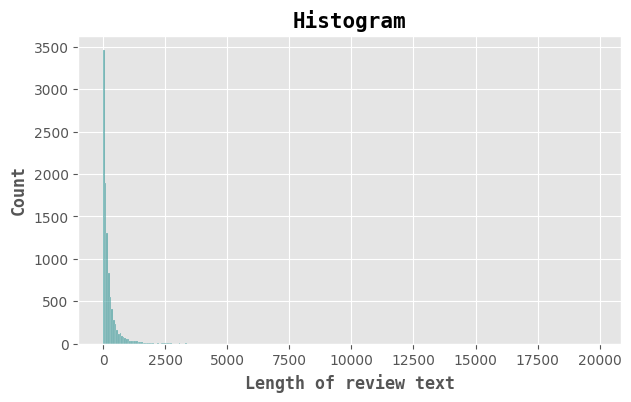

In [24]:
# Histogram plot of the review text length
fig, ax = plt.subplots(figsize = (7,4))
sns.histplot(data = amazon_train, x = "Review_Length", bins = 300, ax = ax, color = 'teal', alpha = 0.5)
ax.set_xlabel("Length of review text", family = 'monospace', size = 12, fontweight = 'bold' )
ax.set_ylabel("Count", family = 'monospace', size = 12, fontweight = 'bold' )
ax.set_title("Histogram", family = 'monospace', size = 15, fontweight = 'bold' )

From above, we see that even though the average review text is around 250 characters long, there are numerous reviews with large number of characters. For efficiency and simplicity, we need to deal with this issue. 

The approach we take is replacing around 1% of the longest review text by its corresponding summary text.

In [25]:
# Finding the length of text above which there exists only around 1% of the data
lengths = np.linspace(0,30000,101)
for length in lengths:
    if abs( amazon_train[ amazon_train.Review_Length > length ].shape[0]/amazon_train.shape[0] * 100 - 1 ) < 0.5:
        cutoff = int(length)
        break
cutoff 

1800

In [26]:
amazon_train[amazon_train.Review_Length > cutoff ].shape[0]/amazon_train.shape[0] * 100

1.2170987532159112

We see that the data with review text length greater than 1800 characters corresponds to around 1% of the entire dataset. We shall replace these reviews by its summary.

In [27]:
# Indices of the largest 1% data
large_length_index = amazon_train[ amazon_train.Review_Length > cutoff ].index.values
large_length_index.size

123

In [28]:
# Replacing the review text with summary text
for index in large_length_index:
    amazon_train.loc[index, "Review"] = amazon_train.loc[index, "Summary"]
    amazon_train.loc[index, "Review_Length"] = len(amazon_train.loc[index, "Summary"])

In [29]:
amazon_train[ amazon_train.Review_Length > cutoff ].index.values.size

0

Text(0.5, 1.0, 'Histogram')

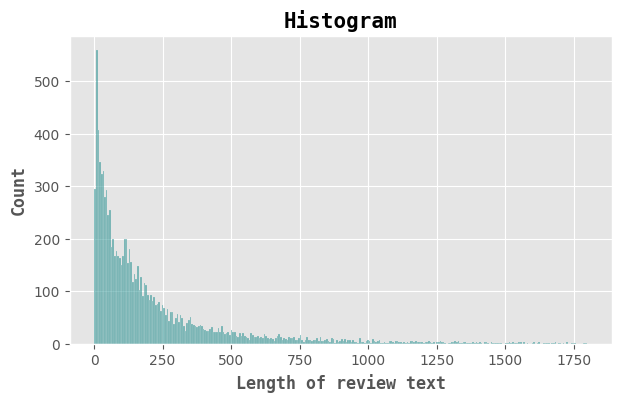

In [30]:
# Histogram plot of the review text length after replacing the largest 1%
fig, ax = plt.subplots(figsize = (7,4))
sns.histplot(data = amazon_train, x = "Review_Length", bins = 300, ax = ax, color = 'teal', alpha = 0.5)
ax.set_xlabel("Length of review text", family = 'monospace', size = 12, fontweight = 'bold' )
ax.set_ylabel("Count", family = 'monospace', size = 12, fontweight = 'bold' )
ax.set_title("Histogram", family = 'monospace', size = 15, fontweight = 'bold' )

In [31]:
# Shortest reviews
amazon_train.Review_Length.min()

1

Since a single letter review is not useful for machine learning, we shall remove these.

In [32]:
# Indices of the single character reviews
length_one_index = amazon_train[ amazon_train.Review_Length == 1].index.values
length_one_index

array([303])

In [33]:
# Dropping the single character reviews
amazon_train.drop(index = length_one_index, inplace = True)

In [34]:
amazon_train.reset_index(inplace = True, drop = True)

## 2) Tokenization

##### In this section, we move onto some basic Tokenization of the review texts using nltk, keras and then use sklearn to vectorize the review texts. 

The training set will be fitted to CountVectorizer to identify all the unique tokens that are present. Then the dataset is transformed such that the entire corpus is vectorized as a bag-of-word (matrix). Lastly, this matrix is turned into a tfidf sparse matrix.

We avoid using a pipeline here so that each step is clarified in detail for learning purposes.

In [35]:
# Useful libraries for predefined stopwords and string tokenizer 
from nltk.corpus import stopwords
from keras.preprocessing.text import text_to_word_sequence

In [36]:
# A function used to remove punctuations, common words and return a list of remaining words in the input string (tokenizer)
def text_process(text):
    """
    1) Remove all punctuations and split text into token using text_to_word_sequence
    2) Remove all common words: through stopwords
    3) Returns list of remaining (useful) tokens for each input string
    """
    
    # Remove punctuations and split text into token list
    clean = []
    for token in text_to_word_sequence(text):
        if token not in stopwords.words('english'):
            clean.append(token)
    
    # Remove common words
    clean_words_2 = []
    for word in clean:
        clean_words_2.append( word.replace('\n','').replace('\t', ''))
        
    return clean_words_2

Vectorization of each review (from token to vector). Again, we avoid using a pipeline so that each step is clarified in detail for learning purposes.

In [37]:
# Used for converting list of tokens to a count vector (bag-of-words)
from sklearn.feature_extraction.text import CountVectorizer 

In [39]:
# Creating a CountVectorizer object: fitted to a corpus (collection) of texts and creates a matrix indicating all the unique words/tokens
# Also transforms a corpus to sparse bag-of-word matrix
bow_transformer = CountVectorizer( analyzer = text_process)

In [40]:
# Fitting to our collection of review texts: identifies all the unique tokens across the entire collection
bow_transformer.fit( amazon_train.Review )

CountVectorizer(analyzer=<function text_process at 0x2a84fff70>)

In [41]:
# Total number of unique tokens after fitting
len( bow_transformer.vocabulary_ )

11902

In [43]:
# Displaying 100 tokens
bow_transformer.get_feature_names_out()[10000:10101]

array(['stopper', 'stoppers', 'stopping', 'stoppped', 'stops', 'storage',
       'store', 'stored', 'stores', 'stories', 'storing', 'storm',
       'storms', 'story', 'stout', 'stove', 'straight', 'straighten',
       'straightforward', 'straighttalk', 'strain', 'strained',
       'strainer', 'strait', 'stranded', 'strange', 'strangers', 'strap',
       'straps', 'stratosphere', 'straw', 'straws', 'stray', 'streak',
       'streaked', 'streaking', 'streaks', 'stream', 'streamed',
       'streaming', 'streamline', 'streamlined', 'street', "street's",
       'strength', 'strengths', 'strenuous', 'stress', 'stretch',
       'stretche', 'stretched', 'stretches', 'stretching', 'stretchy',
       'strict', 'strictly', 'strike', 'striking', 'string', 'strip',
       'stripe', 'stripped', 'stripping', 'strips', 'striving', 'stroke',
       'strokes', 'strong', 'stronger', 'strongest', 'strongly', 'struck',
       'structural', 'structure', 'strudy', 'struggle', 'struggled',
       'struggling'

In [44]:
# Generating a random review text
rand_index = np.random.randint(0,len(amazon_train)-1)
text = amazon_train.iloc[rand_index].Review

In [45]:
# The index, frequency of the token present in text
sparse_text = bow_transformer.transform([text])
print(sparse_text)

  (0, 3889)	1
  (0, 9040)	1


In [46]:
# The corresponding vector/matrix from the sparse matrix
pd.DataFrame.sparse.from_spmatrix(sparse_text)

,0,1,2,3,4,5,6,7,8,9,...,11892,11893,11894,11895,11896,11897,11898,11899,11900,11901
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's transform each review text into a bag-of-word vector i.e. count the number of times each token appears in the text and fill the count vector.

In [47]:
# Vectorising (i.e. creating the bag of word matrix for) the entire dataset
amazon_bow = bow_transformer.transform( amazon_train.Review )

In [48]:
# Checking the shape of the matrix
amazon_bow.shape

(10105, 11902)

Finally we normalise the count bag-of-word matrix by applying TF-IDF (Term Frequency - Inverse Document Frequency) to each element. (Takes into account the entire corpus)

In [49]:
# For normalising the bag-of-words matrix
from sklearn.feature_extraction.text import TfidfTransformer

In [50]:
# tfidf object
tfidf_transformer = TfidfTransformer()

In [51]:
# Fitting
tfidf_transformer.fit(amazon_bow)

TfidfTransformer()

In [52]:
# Taking the (frequency) bag-of-words sparse matrix and normalising it to punish highly frequent tokens
amazon_tfidf = tfidf_transformer.transform(amazon_bow)

In [53]:
text_tfidf = tfidf_transformer.transform(sparse_text)

## 3) Deep Learning: Using feedforward dense neural networks for classification

##### In this section, we train a neural network classifier with Dense layers. Early stopping and Dropout layers are included to avoid overfitting. Rectified Linear Unit activation is used for the hidden layers with two softmax output layers.

Note, even though this is a binary classification problem and thus sigmoid would be a good choice, we use softmax output, with one-hot encoding for personal learning purposes.

In [54]:
# Imports for neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
#Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [56]:
# Converting the sparse bag-of-words (tfidf) matrix to a full DataFrame object for training features
X_train = pd.DataFrame.sparse.from_spmatrix(amazon_tfidf)

In [57]:
# Extracting the values as a matrix for neural network 
X_train = X_train.values

In [64]:
# Extracting the training categorial label
y_train = amazon_train[["Rating"]]

In [65]:
# Converting the rating (1 or 5) into dummy variables - to use as a vector label for neural network (one-got encoding)
y_train = pd.get_dummies(data = y_train, columns = ["Rating"]).values

Now we have to repeat the cleaning and preprocessing for the validate and test sets. This step would have been unified if we had used a pipeline object. 

Firstly, for the validate data.

In [60]:
# Formatting the validate data (same steps as done for the training data)
summary_na_index = amazon_validate[amazon_validate.Summary.isna() == True].index.values
for index in summary_na_index:
    amazon_validate.loc[index, "Summary"] = amazon_validate.loc[index, "Review"]
    
amazon_validate.Summary = amazon_validate.Summary.apply(lambda x: x.lower())

large_length_index = amazon_validate[ amazon_validate.Review_Length > 2100 ].index.values
for index in large_length_index:
    amazon_validate.loc[index, "Review"] = amazon_validate.loc[index, "Summary"]
    amazon_validate.loc[index, "Review_Length"] = len(amazon_validate.loc[index, "Summary"])
    
length_one_index = amazon_validate[ amazon_validate.Review_Length == 1].index.values
amazon_validate.drop(index = length_one_index, inplace = True)
amazon_validate.reset_index(drop = True, inplace = True)

amazon_bow_validate = bow_transformer.transform( amazon_validate.Review )
amazon_tfidf_validate = tfidf_transformer.transform(amazon_bow_validate)

In [61]:
X_validate = pd.DataFrame.sparse.from_spmatrix(amazon_tfidf_validate)
X_validate = X_validate.values
y_validate = amazon_validate[["Rating"]]
y_validate = pd.get_dummies(data = y_validate, columns = ["Rating"]).values

Now, for the test data.

In [62]:
# Formatting the test data (same steps as done for the training data)
summary_na_index = amazon_test[amazon_test.Summary.isna() == True].index.values
for index in summary_na_index:
    amazon_test.loc[index, "Summary"] = amazon_test.loc[index, "Review"]
    
amazon_test.Summary = amazon_test.Summary.apply(lambda x: x.lower())

large_length_index = amazon_test[ amazon_test.Review_Length > 2100 ].index.values
for index in large_length_index:
    amazon_test.loc[index, "Review"] = amazon_test.loc[index, "Summary"]
    amazon_test.loc[index, "Review_Length"] = len(amazon_test.loc[index, "Summary"])
    
length_one_index = amazon_test[ amazon_test.Review_Length == 1].index.values
amazon_test.drop(index = length_one_index, inplace = True)
amazon_test.reset_index(drop = True, inplace = True)

amazon_bow_test = bow_transformer.transform( amazon_test.Review )
amazon_tfidf_test = tfidf_transformer.transform(amazon_bow_test)

In [63]:
X_test = pd.DataFrame.sparse.from_spmatrix(amazon_tfidf_test)
X_test = X_test.values
y_test= amazon_test[["Rating"]]
y_test = pd.get_dummies(data = y_test, columns = ["Rating"]).values

In [ ]:
#import tensorflow
#tensorflow.config.run_functions_eagerly(True)

A rather random choice of neural network architecture used for review text classifier. Softmax output layer used instead of sigmoid just for learning purposes. Typical relu activation for the hidden layers with dropout layers (and early stopage) to avoid overfitting.

In [66]:
# Sequential object to build our neural network
model = Sequential()

model.add(Dense(500, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

2023-05-16 17:01:40.847173: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
# Used to stop the training early if validation losee starts to increase for patience amount of epoch
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 2)

In [68]:
# Training the NN: epochs = # of times training data seen, batch_size = # of data points used for gradient update
model.fit(X_train, y_train, validation_data = (X_validate, y_validate), epochs = 10, batch_size = 15, callbacks = [early_stop])

2023-05-16 17:03:58.817002: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
674/674 [==============================] - 32s 46ms/step - loss: 0.4554 - accuracy: 0.7434 - val_loss: 0.2559 - val_accuracy: 0.8995
Epoch 2/10
674/674 [==============================] - 28s 41ms/step - loss: 0.2115 - accuracy: 0.9270 - val_loss: 0.2503 - val_accuracy: 0.8974
Epoch 3/10
674/674 [==============================] - 28s 42ms/step - loss: 0.1285 - accuracy: 0.9571 - val_loss: 0.2908 - val_accuracy: 0.8980
Epoch 4/10
674/674 [==============================] - 27s 41ms/step - loss: 0.0792 - accuracy: 0.9746 - val_loss: 0.4752 - val_accuracy: 0.8906
Epoch 00004: early stopping


In [69]:
# Predicting output probability for the test dataset
y_prob = model.predict(X_test)

In [70]:
# Rating prediction for the test dataset
y_pred = []
for array in y_prob:
    if array.argmax() == 0:
        y_pred.append(1)
    else:
        y_pred.append(5)

In [71]:
# Classification report 
print(classification_report(amazon_test.Rating.values,y_pred))

              precision    recall  f1-score   support

           1       0.92      0.87      0.90      5093
           5       0.88      0.92      0.90      5008

    accuracy                           0.90     10101
   macro avg       0.90      0.90      0.90     10101
weighted avg       0.90      0.90      0.90     10101



Overall, since the dataset is balanced, we see that our model is able to correctly classify around 90% of the unseen test data with similar recall and precision across both classes.

### 3.1) Including PCA

##### Using Principal component analysis to reduce the features and highlight only the important ones; just to quickly see if it improves performance.

In [72]:
# Importing PCA object
from sklearn.decomposition import PCA

# Instance of a PCA object with 500 features
pca = PCA(n_components = 500)

# Fitting the training data
pca.fit(X_train)

# Extracting the 500 features for train, validate and test data
XX = pca.transform(X_train)
XXv = pca.transform(X_validate)
XXt = pca.transform(X_test)

In [73]:
# Using the same model as before but now with the 500 features extracted using PCA
model = Sequential()

model.add(Dense(500, activation = 'relu', input_dim = XX.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(125, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [74]:
# Traininig the model
model.fit(XX, y_train, validation_data = (XXv, y_validate), epochs = 10, batch_size = 10, callbacks = [early_stop])

Epoch 1/10
1011/1011 [==============================] - 7s 6ms/step - loss: 0.4387 - accuracy: 0.7949 - val_loss: 0.3202 - val_accuracy: 0.8805
Epoch 2/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.2845 - accuracy: 0.8915 - val_loss: 0.2779 - val_accuracy: 0.8815
Epoch 3/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.2599 - accuracy: 0.9054 - val_loss: 0.3041 - val_accuracy: 0.8895
Epoch 4/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.2185 - accuracy: 0.9190 - val_loss: 0.2767 - val_accuracy: 0.8844
Epoch 5/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.1774 - accuracy: 0.9338 - val_loss: 0.3079 - val_accuracy: 0.8896
Epoch 6/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.1725 - accuracy: 0.9377 - val_loss: 0.2891 - val_accuracy: 0.8945
Epoch 00006: early stopping


In [75]:
# Prediction on the test data
y_prob = model.predict(XXt)
y_pred = []
for array in y_prob:
    if array.argmax() == 0:
        y_pred.append(1)
    else:
        y_pred.append(5)

In [76]:
# Classification report
print(classification_report(amazon_test.Rating.values,y_pred))

              precision    recall  f1-score   support

           1       0.91      0.88      0.89      5093
           5       0.88      0.91      0.90      5008

    accuracy                           0.90     10101
   macro avg       0.90      0.90      0.90     10101
weighted avg       0.90      0.90      0.90     10101



Arguably the same result as the previous model with the full tfidf matrix. 

## 4) Conclusion and Future Projects

This notebook presents a very basic NLP project with the use of simple feedforward neural network; review text for cell phone and accessories products sold at amazon is used to develop a deep learning classification model. The model has an accuracy of 90% on a balanced unseen dataset and also a f1-score of 0.9 for each binary class.

In the future, once the relevant skills have been learned, the entire dataset can be used for training and testing and state-of-the-art deep learning architectures could be implemented and compared. The binary classification can be generalised to the multiclass of 1 to 5 star ratings. 

## Author 
Abhay Shrestha